<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/Comparison/1%20ch/paper%20model_seed(14)_109s_1Ch(Oz)_25%20shift_Base_Normal_FitGenerate_60%20Epoch(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
model : paper "Convolutional Network for EEG-Based Biometric"

109 subject
1 channel (Oz)
task: REO 
epoch: 60

TrainResult ([loss , acc])= [0.06618810713135358, 0.9840779467680608]
ValidationResult ([loss , acc])= [0.10523133940825408, 0.970999053030303]
TestResult ([loss , acc])= [0.12559290034132023, 0.9622395833333334]


'''

'\nmodel : paper "Convolutional Network for EEG-Based Biometric"\n\n109 subject\n20 channel [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]\ntrian task: REO \n\nTrainResult ([loss , acc])= [1.94068729002592e-05, 1.0]\nValidationResult ([loss , acc])= [4.485764697902888e-05, 1.0]\nTestResult ([loss , acc])= [2.1977702411363896e-05, 1.0]\n\n'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!pip install mne

In [6]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import numpy as np
import math
import random


# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend


# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Automatically created module for IPython interactive environment


In [0]:
# Parameters:
seed = 14
EpochNum=60
subject_number=109
#list_channel=[21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
list_channel=[61] #Oz
ch_number=len(list_channel)

task_index = [1,2] # task: REO, REC
train_task = 0
test_task = 1
task_number= len(task_index)
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160

sample_per_window = 1920 # 160 * 12 s

Test_sample_shift = 25  # step len
Train_sample_shift = 25  # step len

window_len = 1
batch_size = 64





In [10]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Do you want to set the path:
    /content/drive/My Drive/Deep Results/Database
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.in

In [13]:
# img for each subject
Test_subject_img_number = math.floor((total_sampel_number - sample_per_window ) / Test_sample_shift) +1
Train_subject_img_number = math.floor((total_sampel_number - sample_per_window ) / Train_sample_shift) +1

np.random.seed(seed)  

# subject number shuff
subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

# test img shuff
Test_subject_img_number_array_shuffled=np.arange(Test_subject_img_number)
np.random.shuffle(Test_subject_img_number_array_shuffled)

# train img suff
Train_subject_img_number_array_shuffled=np.arange(Train_subject_img_number)
np.random.shuffle(Train_subject_img_number_array_shuffled)


train_index = len(Train_subject_img_number_array_shuffled) // 2
val_index = train_index + len(Train_subject_img_number_array_shuffled)//4


train_shuff = Train_subject_img_number_array_shuffled[:train_index]
val_shuff = Train_subject_img_number_array_shuffled[train_index:val_index]
test_shuff = Train_subject_img_number_array_shuffled[val_index:]

#test_shuff = Test_subject_img_number_array_shuffled


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)

print(train_number , val_number, test_number)
Train_subject_img_number

154 77 77


308

In [14]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

'''
def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA
'''


'\ndef ProjectionVector(VecA,VecB):\n    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA\n    return Projeted_VecB_on_VecA\n'

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(task,ListChannel, BatchSize,ListRawDataMain,SubjectArrayShuffled,ImageArrayShuffled,WindowLen,SampleShift, SampelNumberPerwindow):
    
    Iter=0
    #ch_number=64
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][task][:64,:total_sampel_number])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
        
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][task][:64,:total_sampel_number])
        
        # Extrac Channel T9 or T10 as Baseline
        #DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        for i in range(len(ListChannel)):
            DataChannelsRaw[s][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() #-DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[s][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[s][i])) # min for each cannel

            DataChannelsNormal[s][i]=normalize_channel_data(DataChannelsRaw[s][i].copy(), i, ch_min, ch_max)


        # Orthogonal Channel
        #DataChannelsOrt[s][0]=DataChannelsNormal[s][0]
        #DataChannelsOrt[s][1]=DataChannelsNormal[s][1]-ProjectionVector(DataChannelsNormal[s][0].copy(),DataChannelsNormal[s][1].copy())*OrthogonalFlag
        
        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  Image=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerwindow), dtype = float)
                  Label=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsNormal[s][i][0+j*SampleShift : SampelNumberPerwindow+ j*SampleShift]
                      Image[Iter][i][z] = ExtractedData.copy()# Data

              Label[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                LabelClass=to_categorical(Label,len(SubjectArrayShuffled))
                TI = np.moveaxis(Image, 1, -1)
                yield TI, LabelClass 

                

In [0]:
#####################################################################################################

# Reset Model and Data Arrays

list_rawdataTemp=list_rawdata.copy()

    
#################################################################################################
# Construct Data Generator

#task, BatchSize,ListRawDataMain,SubjectArrayShuffled, RemoveBaseLineFlag,
#ImageArrayShuffled,WindowLen,SampleShift, SampelNumberPerwindow

GenTrainData=GenerateGeneralData( task= train_task,
                                  ListChannel=list_channel,
                                  BatchSize=batch_size,
                                  ListRawDataMain= list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_number_array_shuffled,
                                  ImageArrayShuffled=train_shuff,
                                  WindowLen=window_len,
                                  SampleShift= Train_sample_shift,
                                  SampelNumberPerwindow =sample_per_window)

GenValidationData =GenerateGeneralData( task= train_task,
                                        ListChannel=list_channel,
                                        BatchSize=batch_size,
                                        ListRawDataMain=list_rawdataTemp.copy(),
                                        SubjectArrayShuffled=subject_number_array_shuffled,
                                        ImageArrayShuffled=val_shuff,
                                        WindowLen=window_len,
                                        SampleShift= Train_sample_shift, 
                                        SampelNumberPerwindow =sample_per_window)

GenTestData=GenerateGeneralData(task= train_task,
                                ListChannel=list_channel,
                                BatchSize=batch_size,
                                ListRawDataMain=list_rawdataTemp.copy(),
                                SubjectArrayShuffled=subject_number_array_shuffled,
                                ImageArrayShuffled=test_shuff,
                                WindowLen=window_len,
                                SampleShift= Test_sample_shift,
                                SampelNumberPerwindow =sample_per_window)

#################################################################################################


In [17]:
# Create Model
model = models.Sequential()
model.add(layers.Conv2D(filters=96, kernel_size=(1,11), activation = 'relu', input_shape = (window_len,sample_per_window,ch_number) ))
print(model.output.shape)
model.add(layers.MaxPooling2D(pool_size=(1,2), strides=4 ))
print(model.output.shape)
model.add(layers.Conv2D(filters=128, kernel_size=(1,9), activation = 'relu' ))
print(model.output.shape)
model.add(layers.MaxPooling2D(pool_size=(1,2), strides=2))
print(model.output.shape)
model.add(layers.Conv2D(filters=256, kernel_size=(1,9), activation = 'relu' ))
print(model.output.shape)
model.add(layers.MaxPooling2D(pool_size=(1,2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(subject_number, activation = 'softmax'))

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])





(?, 1, 1910, 96)

(?, 1, 478, 96)
(?, 1, 470, 128)
(?, 1, 235, 128)
(?, 1, 227, 256)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/60





263/263 [==============================] - 21s 80ms/step - loss: 4.5465 - acc: 0.0233 - val_loss: 4.2866 - val_acc: 0.0316
Epoch 2/60
263/263 [==============================] - 13s 49ms/step - loss: 4.2404 - acc: 0.0398 - val_loss: 3.9166 - val_acc: 0.0492
Epoch 3/60
263/263 [==============================] - 13s 49ms/step - loss: 3.9634 - acc: 0.0605 - val_loss: 3.6110 - val_acc: 0.0721
Epoch 4/60
263/263 [==============================] - 13s 49ms/step - loss: 3.7195 - acc: 0.0794 - val_loss: 3.3058 - val_acc: 0.1715
Epoch 5/60
263/263 [==============================] - 13s 49ms/step - loss: 3.4907 - acc: 0.1028 - val_loss: 3.0130 - val_acc: 0.2320
Epoch 6/60
263/263 [==============================] - 13s 49ms/step - loss: 3.2825 - acc: 0.1282 - val_loss: 2.7657 - val_acc: 0.2815
Epoch 7/60
263/263 [==============================] - 13s 49ms/step - loss: 3.0853 - acc: 0.15

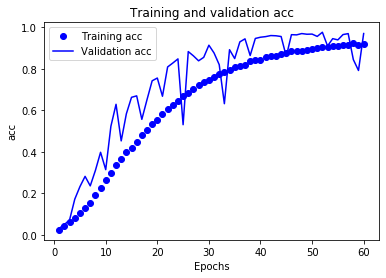

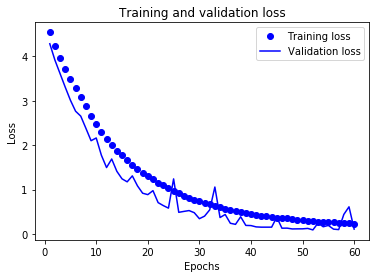

In [18]:
# Train the Model
history = model.fit_generator(epochs =EpochNum,
                              generator=GenTrainData,
                              steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                              validation_data=GenValidationData,
                              validation_steps =np.ceil(val_number*subject_number/batch_size),
                              use_multiprocessing=False,
                              workers=1)

#################################################################################################
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
# plot accuracy
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)


#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()


history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()
